In [ ]:

import numpy as np 
import pandas as pd 
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import webbrowser
import time
from requests.exceptions import HTTPError
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
CLIENT_ID = 'copy paste your client id'
CLIENT_SECRET = 'copy paste your client secret'

# Authenticate and get access token
auth_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

genres = [
    'pop', 'rock', 'hip-hop', 'electronic', 'classical',
    'jazz', 'country', 'blues', 'rap', 'soul',
    'metal', 'punk', 'funk', 'disco', 'house',
    'techno', 'trance', 'indie', 'edm', 'folk'
]

def get_songs_and_features(sp, genres, num_tracks_per_genre=1000):
    tracks = []
    for genre in genres:
        print(f"Fetching tracks for genre: {genre}")
        results = sp.search(q=f'genre:{genre}', limit=50, type='track',market='US')
        while results:
            for track in results['tracks']['items']:
                track_id = track['id']
                track_name = track['name']
                artist_name = track['artists'][0]['name']
                features = sp.audio_features(track_id)[0]
                if features:
                    track_info = {
                        'track_name': track_name,
                        'artist_name': artist_name,
                        'genre': genre,
                        'danceability': features['danceability'],
                        'energy': features['energy'],
                        'valence': features['valence'],
                        'tempo': features['tempo'],
                        'liveness': features['liveness'],
                        'loudness': features['loudness'],
                        'speechiness': features['speechiness'],
                        'acousticness': features['acousticness'],
                        'instrumentalness': features['instrumentalness'],
                        'key': features['key'],
                        'mode': features['mode'],
                        'time_signature': features['time_signature']
                    }
                    tracks.append(track_info)
            if len(tracks) >= num_tracks_per_genre:
                break
            # Fetch the next set of results
            if results['tracks']['next']:
                results = sp.next(results['tracks'])
            else:
                results = None
    return tracks

all_tracks = []
for genre in genres:
    genre_tracks = get_songs_and_features(sp, [genre], num_tracks_per_genre=1000)
    all_tracks.extend(genre_tracks)


df_tracks = pd.DataFrame(all_tracks)
print(df_tracks.head())
df_tracks.to_csv('spotify_tracks_info_us.csv', index=False)


Fetching tracks for genre: pop
Fetching tracks for genre: rock
Fetching tracks for genre: hip-hop
Fetching tracks for genre: electronic
Fetching tracks for genre: classical
Fetching tracks for genre: jazz
Fetching tracks for genre: country
Fetching tracks for genre: blues
Fetching tracks for genre: rap
Fetching tracks for genre: soul
Fetching tracks for genre: metal
Fetching tracks for genre: punk
Fetching tracks for genre: funk
Fetching tracks for genre: disco
Fetching tracks for genre: house
Fetching tracks for genre: techno
Fetching tracks for genre: trance
Fetching tracks for genre: indie
Fetching tracks for genre: edm
Fetching tracks for genre: folk
                       track_name        artist_name genre  danceability  \
0  Holy (feat. Chance The Rapper)      Justin Bieber   pop         0.673   
1                            WOLF            WOOSUNG   pop         0.716   
2                 Beautiful Girls      Sean Kingston   pop         0.748   
3                  skinny dipping

In [5]:
CLIENT_ID = 'copy paste your client id'
CLIENT_SECRET = 'copy paste your secret'
REDIRECT_URI = 'any redirect url, same as the one you enter in your spotify project'

scope = 'user-read-recently-played'

sp_oauth = SpotifyOAuth(client_id=CLIENT_ID,
                        client_secret=CLIENT_SECRET,
                        redirect_uri=REDIRECT_URI,
                        scope=scope)

auth_url = sp_oauth.get_authorize_url()

print(f'Please go to this URL for authorization: {auth_url}')
webbrowser.open(auth_url)

response = input('Enter the URL you were redirected to: ')

code = sp_oauth.parse_response_code(response)
token_info = sp_oauth.get_access_token(code)

# Create a Spotify client
sp = spotipy.Spotify(auth=token_info['access_token'])

def get_audio_features_with_retry(sp, track_id, retries=5):
    for i in range(retries):
        try:
            features = sp.audio_features(track_id)[0]
            return features
        except (spotipy.SpotifyException, HTTPError) as e:
            if e.http_status == 429:
                retry_after = int(e.headers.get("Retry-After", 2))
                print(f"Rate limit exceeded. Retrying in {retry_after} seconds...")
                time.sleep(retry_after)
            else:
                raise e
    raise Exception(f"Failed to retrieve audio features for track {track_id} after {retries} retries.")

#getting user's 10 most recently played tracks
recently_played = sp.current_user_recently_played(limit=10)
tracks = recently_played['items']

track_info_list = []

for item in tracks:
    track = item['track']
    track_id = track['id']
    track_name = track['name']
    artist_name = track['artists'][0]['name']  
    
    features = get_audio_features_with_retry(sp, track_id)
    
    if features:
        track_info = {
            'track_name': track_name,
            'artist_name': artist_name,
            'genre': 'unknown',  
            'danceability': features['danceability'],
            'energy': features['energy'],
            'valence': features['valence'],
            'tempo': features['tempo'],
            'liveness': features['liveness'],
            'loudness': features['loudness'],
            'speechiness': features['speechiness'],
            'acousticness': features['acousticness'],
            'instrumentalness': features['instrumentalness'],
            'key': features['key'],
            'mode': features['mode'],
            'time_signature': features['time_signature']
        }
        track_info_list.append(track_info)

df_tracks = pd.DataFrame(track_info_list)
print(df_tracks)
df_tracks.to_csv('recently_played_tracks.csv', index=False)


Please go to this URL for authorization: https://accounts.spotify.com/authorize?client_id=788f5e4fe8f7424db1ee28ad110fb3b2&response_type=code&redirect_uri=https%3A%2F%2Fwww.kaggle.com&scope=user-read-recently-played


Enter the URL you were redirected to:  https://www.kaggle.com/?code=AQDSLxUydC7AHxmw_8kAMi_IHDDabqN9Ks8Iu29nkobIJrRKohb1gOtSZmNCf44mbkLxELz2FNBdbiMfH2rw1dZ4RU1286rxVJGTHIV5U86U0L-PjjyVOT6VSHHrktQmGeoTyD6rWJQHiiF9m5rz1bgKgIu8_cLtLTVfJtEvd7MUOV3jbgYpAHgym5sfUVSvU788fhA


/tmp/ipykernel_33/3361335126.py:34: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  token_info = sp_oauth.get_access_token(code)


                          track_name                artist_name    genre  \
0                   BUTTERFLY EFFECT               Travis Scott  unknown   
1                   BUTTERFLY EFFECT               Travis Scott  unknown   
2                           Hey Baby  Dimitri Vegas & Like Mike  unknown   
3                           Hey Baby  Dimitri Vegas & Like Mike  unknown   
4                   BUTTERFLY EFFECT               Travis Scott  unknown   
5  Hell N Back (feat. Summer Walker)                      Bakar  unknown   
6             Fantasy (feat. O.D.B.)               Mariah Carey  unknown   
7                    Dance The Night                   Dua Lipa  unknown   
8                              Aayat               Arijit Singh  unknown   
9             Fantasy (feat. O.D.B.)               Mariah Carey  unknown   

   danceability  energy  valence    tempo  liveness  loudness  speechiness  \
0         0.763   0.628    0.193  140.958    0.1140    -5.850       0.0500   
1      

In [2]:
my_tracks=pd.read_csv("path/recently_played_tracks.csv")
base=pd.read_csv("path/spotify_tracks_info_us.csv")

In [3]:
my_tracks.drop_duplicates(inplace=True)
my_tracks.reset_index(drop=True, inplace=True)
print(my_tracks.head())

                          track_name                artist_name    genre  \
0                   BUTTERFLY EFFECT               Travis Scott  unknown   
1                           Hey Baby  Dimitri Vegas & Like Mike  unknown   
2  Hell N Back (feat. Summer Walker)                      Bakar  unknown   
3             Fantasy (feat. O.D.B.)               Mariah Carey  unknown   
4                    Dance The Night                   Dua Lipa  unknown   

   danceability  energy  valence    tempo  liveness  loudness  speechiness  \
0         0.763   0.628    0.193  140.958    0.1140    -5.850        0.050   
1         0.708   0.908    0.850   90.026    0.0814    -3.579        0.184   
2         0.640   0.673    0.736  209.942    0.1130    -4.519        0.563   
3         0.837   0.547    0.821  102.496    0.0500    -9.658        0.116   
4         0.671   0.845    0.775  110.056    0.3290    -4.930        0.048   

   acousticness  instrumentalness  key  mode  time_signature  
0        0.

In [6]:
base.head()

,track_name,artist_name,genre,danceability,energy,valence,tempo,liveness,loudness,speechiness,acousticness,instrumentalness,key,mode,time_signature
0,Holy (feat. Chance The Rapper),Justin Bieber,pop,0.673,0.704,0.372,86.919,0.0898,-8.056,0.3600,0.1960,0.00000,6,1,4
1,WOLF,WOOSUNG,pop,0.716,0.403,0.286,96.040,0.0940,-9.267,0.0496,0.6540,0.00241,7,1,4
2,Beautiful Girls,Sean Kingston,pop,0.748,0.653,0.709,130.002,0.3060,-6.545,0.0680,0.1390,0.00000,9,1,4
3,skinny dipping,Sabrina Carpenter,pop,0.452,0.536,0.426,122.375,0.1400,-8.864,0.1400,0.2610,0.00000,4,1,5
4,Empire,Marie-Mai,pop,0.596,0.651,0.496,91.995,0.1050,-7.040,0.0534,0.0162,0.00000,6,0,4


In [10]:
base['genre'].value_counts()

genre
pop           100
metal         100
indie         100
trance        100
techno        100
house         100
disco         100
funk          100
punk          100
soul          100
rock          100
rap           100
blues         100
country       100
jazz          100
classical     100
electronic    100
hip-hop       100
edm           100
Name: count, dtype: int64

In [3]:
base['artist_name'].value_counts()

artist_name
Armin van Buuren           16
Cosmic Gate                 8
George Frideric Handel      7
Wolfgang Amadeus Mozart     7
Tiësto                      6
                           ..
Bill Monroe                 1
Lee Hazlewood               1
Hank Williams               1
Dottie West                 1
TOFIE                       1
Name: count, Length: 1701, dtype: int64

In [11]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        1900 non-null   object 
 1   artist_name       1900 non-null   object 
 2   genre             1900 non-null   object 
 3   danceability      1900 non-null   float64
 4   energy            1900 non-null   float64
 5   valence           1900 non-null   float64
 6   tempo             1900 non-null   float64
 7   liveness          1900 non-null   float64
 8   loudness          1900 non-null   float64
 9   speechiness       1900 non-null   float64
 10  acousticness      1900 non-null   float64
 11  instrumentalness  1900 non-null   float64
 12  key               1900 non-null   int64  
 13  mode              1900 non-null   int64  
 14  time_signature    1900 non-null   int64  
dtypes: float64(9), int64(3), object(3)
memory usage: 222.8+ KB


In [12]:
base.describe()

,danceability,energy,valence,tempo,liveness,loudness,speechiness,acousticness,instrumentalness,key,mode,time_signature
count,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000
mean,0.590822,0.638936,0.473038,121.866547,0.208520,-9.484531,0.097108,0.280698,0.288476,5.357895,0.618947,3.920000
std,0.175852,0.264016,0.265965,27.365144,0.180562,5.540061,0.107317,0.337494,0.377470,3.624171,0.485773,0.407822
min,0.061600,0.000998,0.000010,50.396000,0.016200,-45.699000,0.023200,0.000001,0.000000,0.000000,0.000000,1.000000
25%,0.474000,0.460750,0.247000,102.111500,0.096700,-11.461750,0.039900,0.005678,0.000002,2.000000,0.000000,4.000000
50%,0.609500,0.689000,0.464500,123.010000,0.130000,-8.058000,0.054100,0.103000,0.005365,5.000000,1.000000,4.000000
75%,0.731250,0.861000,0.687250,135.840250,0.277250,-5.873250,0.102000,0.525000,0.728000,9.000000,1.000000,4.000000
max,0.984000,1.000000,0.981000,216.300000,0.994000,5.179000,0.959000,0.996000,0.980000,11.000000,1.000000,5.000000


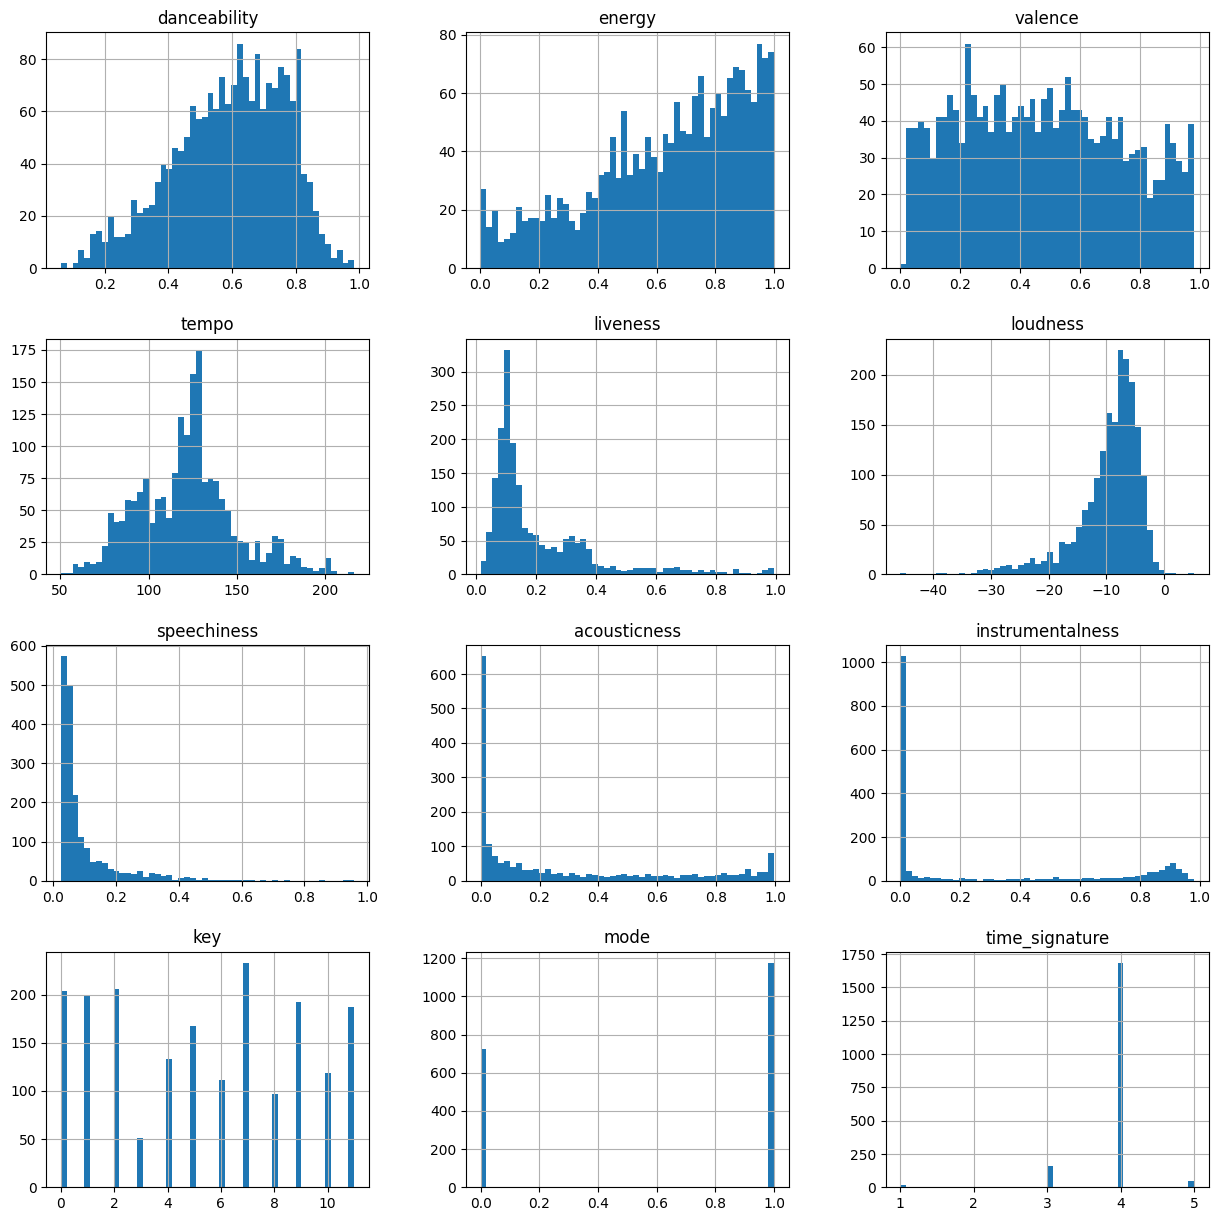

In [14]:
base.hist(bins=50,figsize=(15,15))
# display histogram
plt.show()

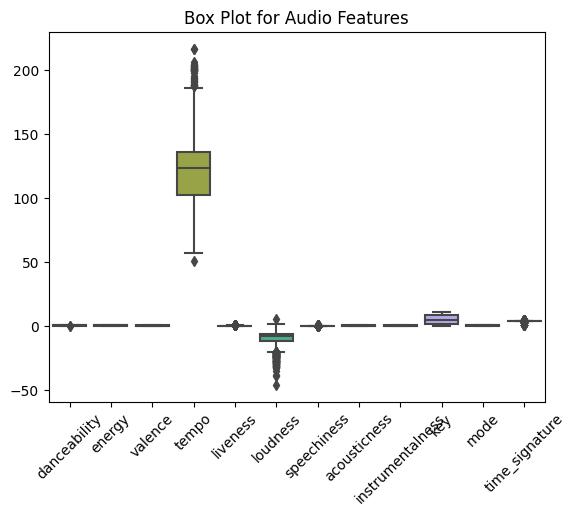

In [10]:
# base.boxplot(figsize=(15, 10))
sns.boxplot(data=base)
plt.title('Box Plot for Audio Features')
plt.xticks(rotation=45)
plt.show()

In [5]:
categorical_columns=['track_name','artist_name','genre','key','mode']
numerical_columns=[col for col in base.columns if col not in categorical_columns]
print(numerical_columns)
cat_columns=['key','mode']

['danceability', 'energy', 'valence', 'tempo', 'liveness', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'time_signature']


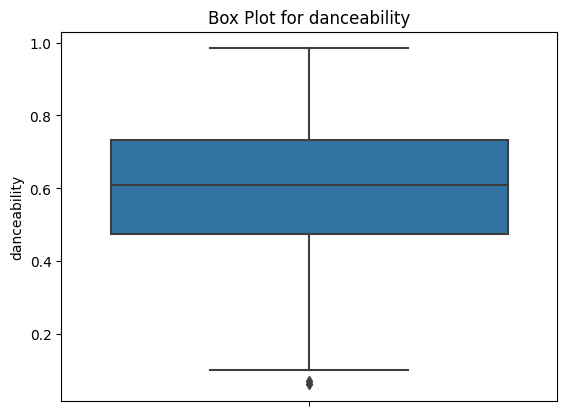

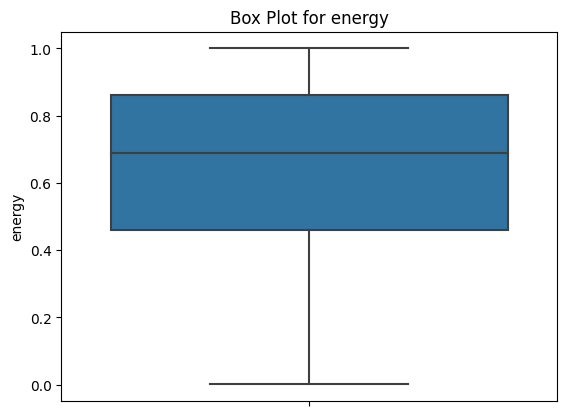

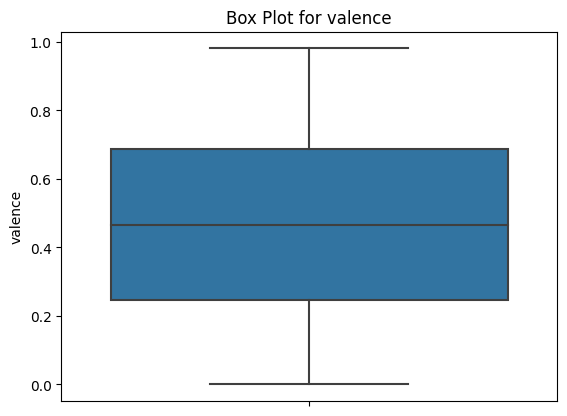

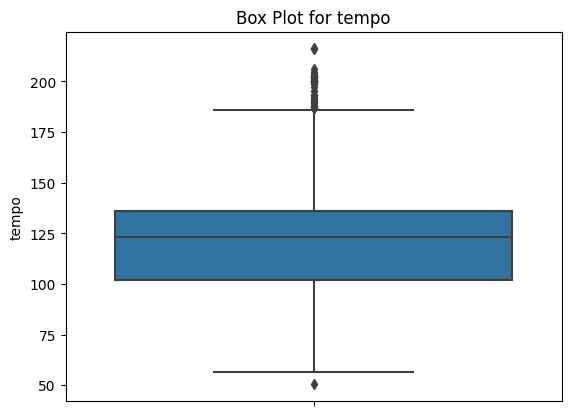

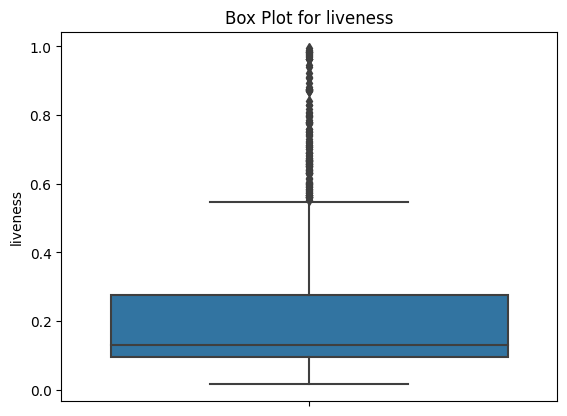

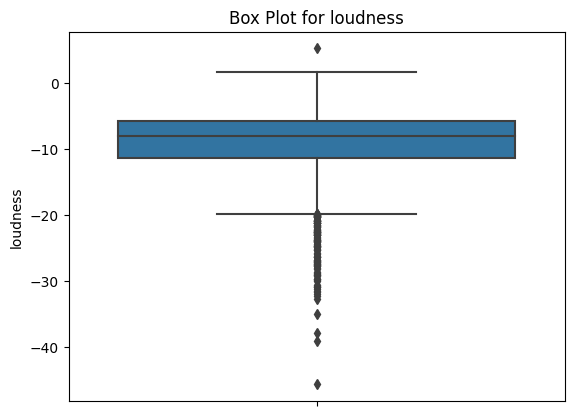

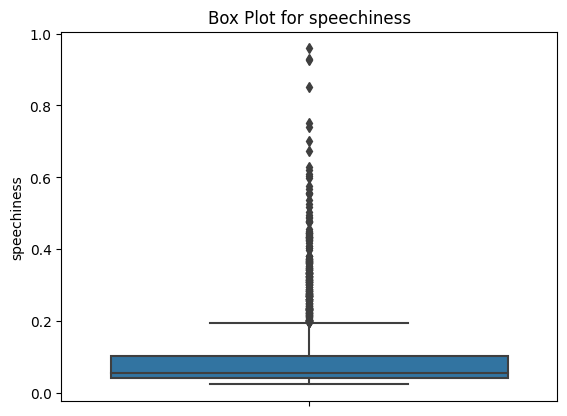

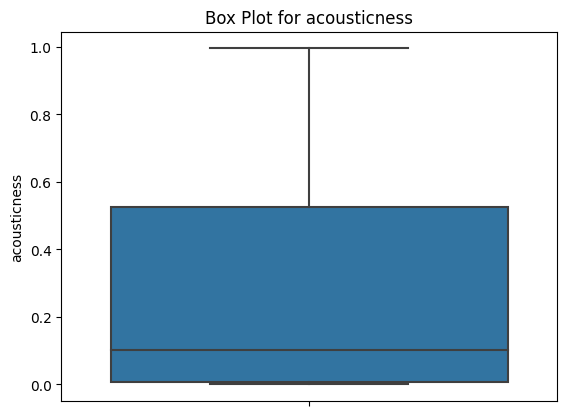

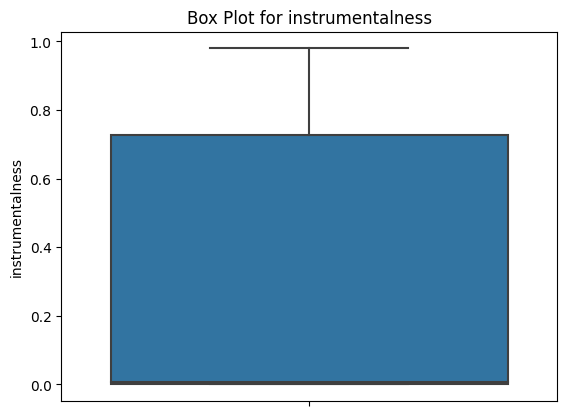

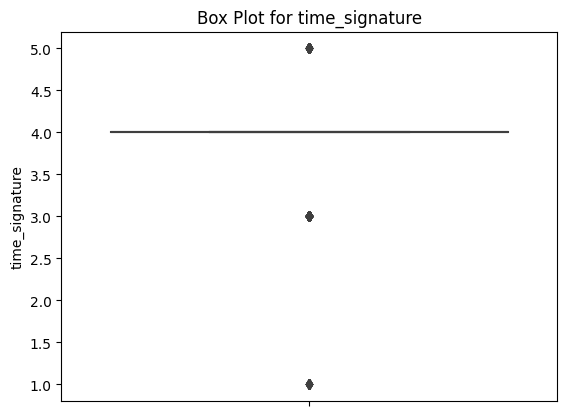

In [18]:
for column in numerical_columns:
        plt.figure()  
        sns.boxplot(y=base[column])
        plt.title(f'Box Plot for {column}')
        plt.show()

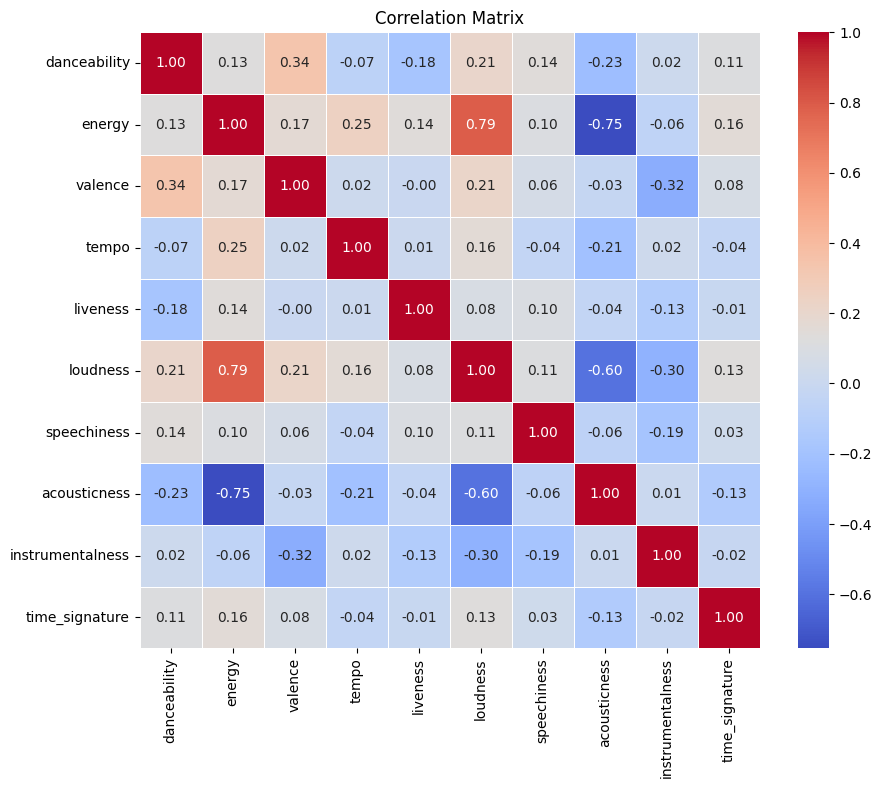

In [19]:
corr_matrix = base[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [6]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

res = base.copy(deep=True) 
base.drop(['artist_name'], axis=1)
base.drop(['genre'], axis=1)
base.drop(['track_name'], axis=1)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, cat_columns)
    ])
preprocessed_data = preprocessor.fit_transform(base)

feature_names=numerical_columns+cat_columns
new_features=preprocessor.get_feature_names_out()
p_base = pd.DataFrame(preprocessed_data.toarray() if hasattr(preprocessed_data, "toarray") else preprocessed_data,columns=new_features)

print(p_base)





      num__danceability  num__energy  num__valence  num__tempo  num__liveness  \
0              0.467436     0.246506     -0.379993   -1.277419      -0.657674   
1              0.712024    -0.893877     -0.703429   -0.944024      -0.634408   
2              0.894043     0.053285      0.887427    0.297371       0.540013   
3             -0.789634    -0.389987     -0.176905    0.018585      -0.379581   
4              0.029452     0.045707      0.086358   -1.091878      -0.573471   
...                 ...          ...           ...         ...            ...   
1895           0.262664    -0.344523      1.308646    0.188591      -0.451597   
1896           0.541381     0.363954      1.793801   -0.439125       0.988730   
1897           0.660831     0.094960      0.308250    0.004549       2.368120   
1898          -1.802116    -0.094472      1.669692   -0.653907      -0.351882   
1899           0.086333     1.045910     -0.180666    1.394676      -0.703654   

      num__loudness  num__s

In [7]:
preprocessed_data_mine = preprocessor.transform(my_tracks)

feature_names=numerical_columns+cat_columns
new_features=preprocessor.get_feature_names_out()
tracks = pd.DataFrame(preprocessed_data_mine.toarray() if hasattr(preprocessed_data_mine, "toarray") else preprocessed_data_mine,columns=new_features)

print(tracks)

   num__danceability  num__energy  num__valence  num__tempo  num__liveness  \
0           0.979365    -0.041431     -1.053192    0.697840      -0.523613   
1           0.666519     1.019390      1.417712   -1.163850      -0.704208   
2           0.279728     0.129058      0.988971    3.219374      -0.529153   
3           1.400284    -0.348312      1.308646   -0.708041      -0.878155   
4           0.456060     0.780705      1.135646   -0.431705       0.667426   
5          -1.142296     0.019187     -0.128013    2.274822      -0.615573   

   num__loudness  num__speechiness  num__acousticness  num__instrumentalness  \
0       0.656218         -0.439078          -0.674554              -0.764437   
1       1.066249          0.809883          -0.781251              -0.764437   
2       0.896531          4.342391           0.021642              -0.764431   
3      -0.031320          0.176082          -0.710416              -0.764437   
4       0.822325         -0.457719          -0.770581

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca_columns=['num__energy','num__loudness','num__acousticness']
preprocess = ColumnTransformer(
    transformers=[
        ('PCA DTM', pca, pca_columns)
    ],
    remainder='passthrough'
)

trans = preprocess.fit_transform(p_base)
result_names=preprocess.get_feature_names_out()
result_df = pd.DataFrame(trans,columns=result_names)

In [9]:
tracks_transform = preprocess.transform(tracks)
result_names=preprocess.get_feature_names_out()
result_df_tracks= pd.DataFrame(tracks_transform ,columns=result_names)

In [20]:
result_df

,PCA DTM__pca0,remainder__num__danceability,remainder__num__valence,remainder__num__tempo,remainder__num__liveness,remainder__num__speechiness,remainder__num__instrumentalness,remainder__num__time_signature,remainder__cat__key_0,remainder__cat__key_1,...,remainder__cat__key_4,remainder__cat__key_5,remainder__cat__key_6,remainder__cat__key_7,remainder__cat__key_8,remainder__cat__key_9,remainder__cat__key_10,remainder__cat__key_11,remainder__cat__mode_0,remainder__cat__mode_1
0,-0.435680,0.467436,-0.379993,-1.277419,-0.657674,2.450309,-0.764437,0.196215,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.135083,0.712024,-0.703429,-0.944024,-0.634408,-0.442806,-0.758051,0.196215,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.567654,0.894043,0.887427,0.297371,0.540013,-0.271307,-0.764437,0.196215,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.140176,-0.789634,-0.176905,0.018585,-0.379581,0.399776,-0.764437,2.648909,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.714799,0.029452,0.086358,-1.091878,-0.573471,-0.407388,-0.764437,0.196215,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,-0.084340,0.262664,1.308646,0.188591,-0.451597,1.508928,-0.764437,0.196215,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1896,-0.846365,0.541381,1.793801,-0.439125,0.988730,2.636721,-0.764437,-7.161864,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1897,-0.646575,0.660831,0.308250,0.004549,2.368120,-0.452127,0.955359,0.196215,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1898,0.011742,-1.802116,1.669692,-0.653907,-0.351882,-0.521099,1.456193,0.196215,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

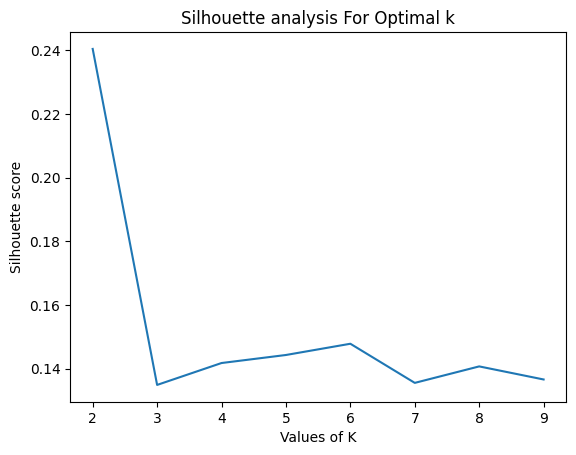

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
range_n_clusters = range(2,10)
silhouette_avg = []
for num_clusters in range_n_clusters:
 kmeans = KMeans(n_clusters=num_clusters)
 silhouette_avg.append(silhouette_score(result_df, kmeans.fit_predict(result_df)))
plt.plot(range_n_clusters,silhouette_avg)
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

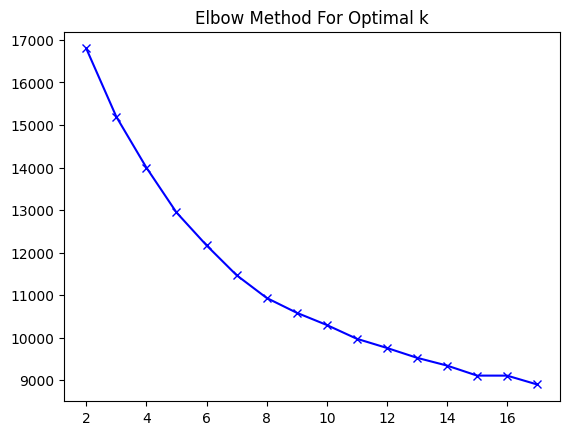

In [25]:
Sum_of_squared_distances = []
K = range(2,18)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(result_df)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
# plt.xlabel(‘Values of K’) 
# plt.ylabel(‘Sum of squared distances/Inertia’) 
plt.title('Elbow Method For Optimal k')
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


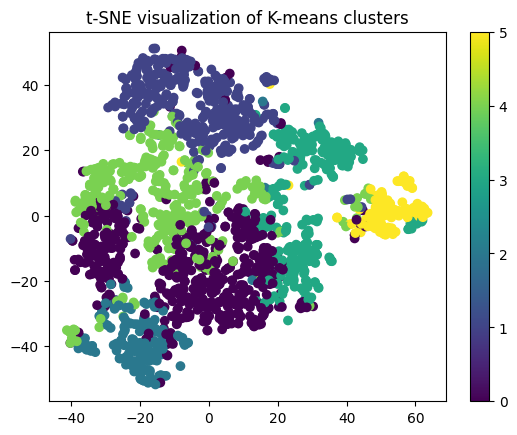

In [11]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
kmeans = KMeans(n_clusters=6)
kmeans.fit(result_df)
cluster_assignments = kmeans.labels_
cluster_centers_kmeans = kmeans.cluster_centers_
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(result_df)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_assignments, cmap='viridis')
plt.title('t-SNE visualization of K-means clusters')
plt.colorbar()
plt.show()


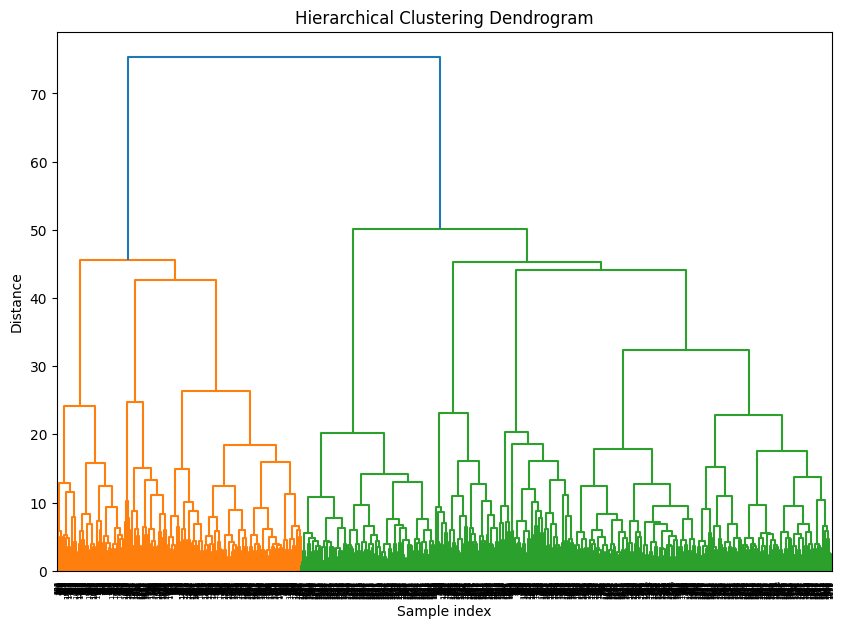

In [27]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(result_df, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()


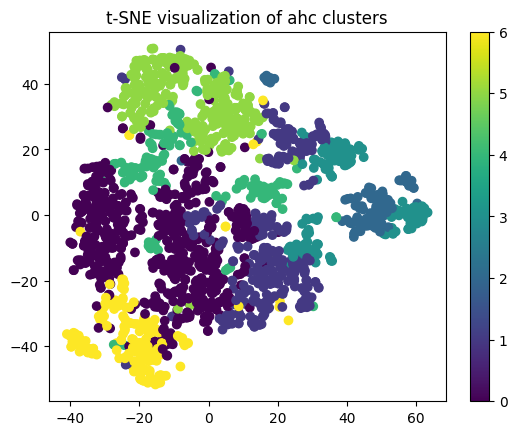

In [25]:
from sklearn.cluster import AgglomerativeClustering
from numpy import unique
from sklearn.manifold import TSNE

agg_mdl = AgglomerativeClustering(n_clusters=7)
agg_result = agg_mdl.fit_predict(result_df)
agg_clusters = unique(agg_result)
unique_labels = np.unique(agg_mdl.labels_)
cluster_rep_agg = []
for label in unique_labels:
    cluster_points = result_df[agg_mdl.labels_ == label]
    cluster_rep_agg.append(np.mean(cluster_points, axis=0))
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(result_df)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=agg_result, cmap='viridis')
plt.title('t-SNE visualization of ahc clusters')
plt.colorbar()
plt.show()

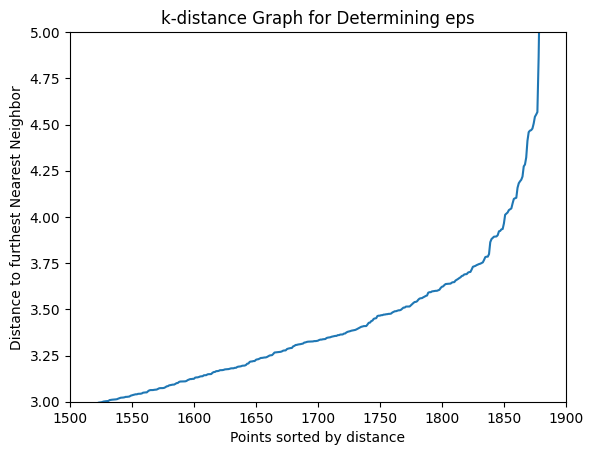

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=44)
neighbors_fit = neighbors.fit(result_df)
distances, indices = neighbors_fit.kneighbors(result_df)
distances = np.sort(distances[:, -1], axis=0)

plt.plot(distances)
plt.ylabel('Distance to furthest Nearest Neighbor')
plt.xlabel('Points sorted by distance')
plt.title('k-distance Graph for Determining eps')
plt.xlim(1500, 1900)  #zooming in here
plt.ylim(3, 5)
plt.show()


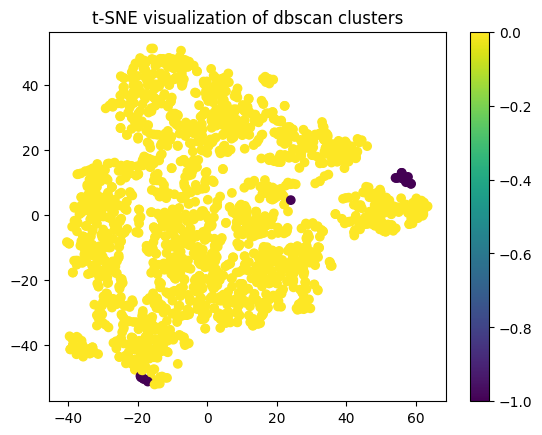

In [19]:
from numpy import where
from numpy import unique
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

dbscan_model = DBSCAN(eps=3.75, min_samples=44)
dbscan_result = dbscan_model.fit_predict(result_df)
unique_labels = np.unique(dbscan_result)
unique_labels = [x for x in unique_labels if x != -1]
cluster_rep_dbscan = []
for label in unique_labels:
    cluster_points = result_df[dbscan_result == label]
    cluster_rep_dbscan.append(np.mean(cluster_points, axis=0))
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(result_df)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_result, cmap='viridis')
plt.title('t-SNE visualization of dbscan clusters')
plt.colorbar()
plt.show()

**KMEANS**

In [21]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
result_df_tracks_np = result_df_tracks.values
combined_features = np.mean(result_df_tracks_np, axis=0)
combined_features = np.array(combined_features).reshape(1, -1)
similarities = cosine_similarity(combined_features, cluster_centers_kmeans)
closest_cluster_index = np.argmax(similarities)
songs_in_closest_cluster = base[cluster_assignments == closest_cluster_index]
top_n_recommendations = songs_in_closest_cluster[:5]['track_name']
print(top_n_recommendations)

1               WOLF
2    Beautiful Girls
3     skinny dipping
4             Empire
5           Barriers
Name: track_name, dtype: object


In [30]:
k_labels=np.unique(cluster_assignments)
gen={}
for i in k_labels:
    gen[i] = base[cluster_assignments == i]['genre'].value_counts().to_dict()
for cluster, counts in gen.items():
    print(f"Cluster {cluster}:")
    for genre, count in counts.items():
        print(f"    {genre}: {count}")
    

Cluster 0:
    disco: 62
    pop: 55
    soul: 50
    hip-hop: 48
    blues: 48
    funk: 44
    indie: 44
    country: 43
    rock: 42
    punk: 33
    rap: 31
    edm: 28
    house: 17
    electronic: 15
    metal: 11
    jazz: 7
    techno: 6
    trance: 4
Cluster 1:
    house: 74
    techno: 67
    electronic: 59
    trance: 56
    edm: 33
    funk: 23
    disco: 21
    metal: 13
    soul: 11
    rock: 10
    indie: 10
    jazz: 6
    punk: 5
    rap: 3
    pop: 3
    hip-hop: 2
    blues: 1
Cluster 2:
    rap: 54
    hip-hop: 39
    funk: 20
    edm: 10
    pop: 9
    soul: 6
    country: 5
    blues: 5
    electronic: 4
    disco: 4
    techno: 4
    trance: 3
    indie: 3
    jazz: 2
    rock: 2
    metal: 2
    punk: 1
Cluster 3:
    classical: 86
    jazz: 63
    country: 31
    blues: 18
    soul: 17
    indie: 15
    rock: 11
    pop: 8
    electronic: 6
    metal: 5
    disco: 5
    punk: 4
    house: 3
    rap: 3
    funk: 2
    trance: 2
    hip-hop: 1
Cluster 4:
    meta

**AGGLOMERATIVE_CLUSTERING**

In [31]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
result_df_tracks_np = result_df_tracks.values
combined_features = np.mean(result_df_tracks_np, axis=0)
combined_features = np.array(combined_features).reshape(1, -1)
similarities = cosine_similarity(combined_features, cluster_rep_agg)
closest_cluster_index = np.argmax(similarities)
songs_in_closest_cluster = base[agg_result == closest_cluster_index]
top_n_recommendations = songs_in_closest_cluster[:5]['track_name']
print(top_n_recommendations)

2     Beautiful Girls
4              Empire
5            Barriers
9        So Necessary
10         In the Mix
Name: track_name, dtype: object


In [34]:
a_labels=np.unique(agg_result)
gen={}
for i in a_labels:
    gen[i] = base[agg_result == i]['genre'].value_counts().to_dict()
for cluster, counts in gen.items():
    print(f"Cluster {cluster}:")
    for genre, count in counts.items():
        print(f"    {genre}: {count}")

Cluster 0:
    punk: 68
    disco: 62
    metal: 56
    hip-hop: 45
    rock: 44
    funk: 40
    pop: 40
    edm: 40
    indie: 39
    blues: 36
    rap: 32
    soul: 31
    electronic: 25
    house: 20
    country: 16
    trance: 16
    techno: 15
    jazz: 5
Cluster 1:
    country: 51
    jazz: 47
    indie: 33
    blues: 29
    soul: 28
    rock: 24
    pop: 22
    rap: 15
    funk: 11
    electronic: 10
    punk: 10
    disco: 10
    hip-hop: 10
    house: 8
    edm: 8
    classical: 6
    metal: 4
    techno: 1
    trance: 1
Cluster 2:
    pop: 17
    blues: 12
    country: 9
    techno: 9
    soul: 9
    rock: 8
    metal: 7
    indie: 6
    trance: 5
    edm: 5
    punk: 4
    electronic: 3
    jazz: 2
    classical: 2
    funk: 2
    house: 2
    rap: 1
    hip-hop: 1
Cluster 3:
    classical: 84
    jazz: 39
    indie: 7
    rock: 6
    country: 6
    soul: 6
    blues: 5
    metal: 3
    techno: 3
    pop: 2
    disco: 2
    trance: 2
    electronic: 1
    funk: 1
Cluster 4:

**DBSCAN**

In [32]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
result_df_tracks_np = result_df_tracks.values
combined_features = np.mean(result_df_tracks_np, axis=0)
combined_features = np.array(combined_features).reshape(1, -1)
similarities = cosine_similarity(combined_features, cluster_rep_dbscan)
closest_cluster_index = np.argmax(similarities)
songs_in_closest_cluster = base[dbscan_result == closest_cluster_index]
top_n_recommendations = songs_in_closest_cluster[:5]['track_name']
print(top_n_recommendations)

0    Holy (feat. Chance The Rapper)
1                              WOLF
2                   Beautiful Girls
3                    skinny dipping
4                            Empire
Name: track_name, dtype: object
